In [ ]:
import numpy as np 
import pandas as pd
import os
#lectura del csv
dr = pd.read_csv('train.csv', index_col=0)
#visualización de los datos con pandas
# re organizar la tabla de manera random
print(dr)
dr = dr.sample(frac=1)

print(dr.shape)
print(dr.head(10))
    
from sklearn.model_selection import train_test_split

train_set, valid_set = train_test_split(dr, test_size=0.2, random_state=42)

print('train',train_set.shape)
print(train_set)

print('valid',valid_set.shape)
print(valid_set)

import shutil 
from shutil import copyfile
# borrar directorio temporal
if os.path.exists('temp'):
    shutil.rmtree('temp')

os.mkdir('temp/')

#train directory

os.mkdir('temp/train/')
os.mkdir('temp/train/con acaros/')
os.mkdir('temp/train/sin acaros/')

#validation directory 


os.mkdir('temp/valid/')
os.mkdir('temp/valid/con acaros/')
os.mkdir('temp/valid/sin acaros/')

source = 'images/'

train_dir= 'temp/train/' 

valid_dir = 'temp/valid/'

In [ ]:
for index, data in train_set.iterrows():
    labels = dr.columns[np.argmax(data)]
    # print(labels)
    filepath = os.path.join(source, index + '.JPG')       
#   print(os.path.join(source, index, '.jpg'))
    destination = os.path.join(train_dir, labels, index + '.JPG')
    # print(filepath, 'fileeepath')
    # print('dest', destination)
    copyfile(filepath, destination)
    
for subdir in os.listdir(train_dir):
    print(subdir, len(os.listdir(os.path.join(train_dir, subdir))))


#copy images to valid dir

for index, data in valid_set.iterrows():
    labels = dr.columns[np.argmax(data)]
    filepath = os.path.join(source, index + '.JPG')
    destination = os.path.join(valid_dir, labels, index + '.JPG')
    copyfile(filepath, destination)         
for subdir in os.listdir(valid_dir):
    print(subdir, len(os.listdir(os.path.join(train_dir, subdir))))  

In [ ]:
#### Explore IMAGES #######
con_acaros_dir = os.path.join(train_dir, 'con acaros/') 
sin_acaros_dir = os.path.join(train_dir, 'sin acaros/')            

con_acaros_files = os.listdir(con_acaros_dir)
sin_acaros_files = os.listdir(sin_acaros_dir)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_con_acaros = [os.path.join(con_acaros_dir, fname) for fname in con_acaros_files[pic_index-2:pic_index]]
next_sin_acaros = [os.path.join(sin_acaros_dir, fname) for fname in sin_acaros_files[pic_index-2:pic_index]]

nrows = 3
ncols = 2

fig = plt.gcf()
fig.set_size_inches(ncols*7,nrows*7)

for i, img_path in enumerate(next_con_acaros+next_sin_acaros):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('off') # no muestra los ejes de las lineas divisoras
    img = mpimg.imread(img_path)
    plt.title(img_path.split('/')[-2])
    plt.imshow(img)

Keras Image Generator API

In [11]:
import tensorflow as tf 
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

train_dir= 'temp/train/' 

valid_dir = 'temp/valid/'

train_data_gen=tf.keras.preprocessing.image.ImageDataGenerator(
    fill_mode='nearest',
    interpolation_order=1,
    dtype=None
)
val_data_gen = ImageDataGenerator(rescale = 1./255)

train_gen = train_data_gen.flow_from_directory(train_dir, target_size = (150,150), class_mode ='categorical', batch_size = 32)
val_gen = val_data_gen.flow_from_directory(valid_dir, target_size = (150,150), class_mode ='categorical', batch_size = 32)

Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


CNN modeling

In [3]:
import tensorflow as tf 
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) 
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cnn.h5", save_best_only=True)

history = model.fit(train_gen, epochs=20, steps_per_epoch=50, 
                    validation_data = val_gen, validation_steps=12, callbacks=[early_stopping_cb, checkpoint_cb])

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

In [2]:
import tensorflow as tf
model = tf.keras.models.load_model("cnn.h5") # rollback to best model

In [7]:
from keras_preprocessing import image
import pandas as pd
import os
import numpy as np
test_set = pd.read_csv("test.csv", index_col=0)
source = 'images/'
X_test = []
for index, data in test_set.iterrows():
    filepath = os.path.join(source, index + ".jpg")
    img = image.load_img(filepath, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    X_test.append(x)
    
X_test = np.vstack(X_test) / 255

In [12]:
y_pred = model.predict(X_test, batch_size=10)
df_out = pd.concat([test_set.reset_index(), pd.DataFrame(y_pred, columns = train_gen.class_indices.keys())], axis=1).set_index("imageid")
df_out.to_csv('sample_submission.csv')
df_out

61/61 [==============================] - 4s 72ms/step


con acaros  sin acaros
imageid                        
test0      0.794184    0.205816
test1      0.057837    0.942163
test10     0.185106    0.814894
test100    0.622617    0.377383
test101    0.853197    0.146803
...             ...         ...
test95     0.668958    0.331042
test96     0.931111    0.068889
test97     0.614587    0.385413
test98     0.834227    0.165773
test99     0.132794    0.867206

[603 rows x 2 columns]

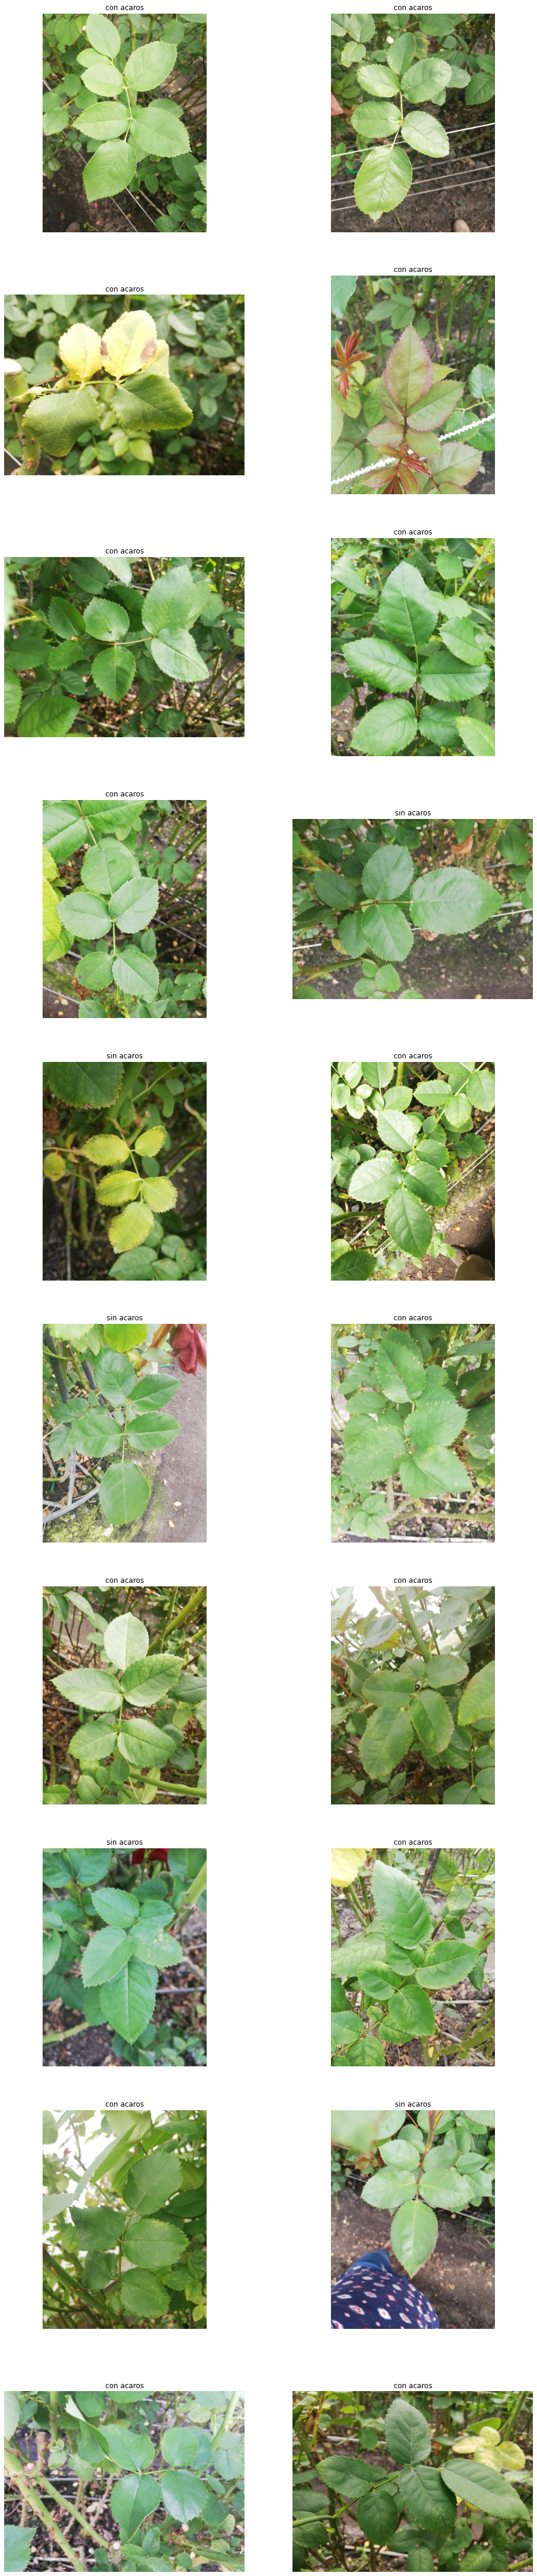

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
nrows = 10
ncols = 2

fig = plt.gcf()
fig.set_size_inches(ncols*8, nrows*8)

for i, (idx, row) in enumerate(df_out.sample(nrows*ncols).iterrows()):
    filepath = filepath = os.path.join(source, idx + ".jpg")
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(filepath)
    plt.title(df_out.columns[np.argmax(row)])
    plt.imshow(img)
    
plt.show()

In [20]:
# predicition item by item
print(y_pred[157])

[0.02761374 0.97238624]


In [16]:
model.evaluate(val_gen)

19/19 [==============================] - 211s 11s/step - loss: 0.3576 - accuracy: 0.8617


[0.3576418161392212, 0.8616666793823242]

In [26]:
df_out.sort_values(by='con acaros', ascending=False)

con acaros  sin acaros
imageid                        
test576    0.999356    0.000644
test70     0.999115    0.000885
test4      0.998821    0.001179
test539    0.998561    0.001439
test417    0.998451    0.001549
...             ...         ...
test52     0.000620    0.999380
test26     0.000443    0.999557
test17     0.000420    0.999580
test30     0.000338    0.999662
test27     0.000002    0.999998

[603 rows x 2 columns]

In [29]:
print(y_pred[1])

[0.05783667 0.94216335]
